In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:

BOW_train = pd.read_csv('../project_data/data/bag-of-words/bow.train.csv').replace({'label': {0: -1}})
BOW_test = pd.read_csv('../project_data/data/bag-of-words/bow.test.csv').replace({'label': {0: -1}})
BOW_eval = pd.read_csv('../project_data/data/bag-of-words/bow.eval.anon.csv').replace({'label': {0: -1}})

In [ ]:
glove_train = pd.read_csv('../project_data/data/glove/glove.train.csv').replace({'label': {0: -1}})
glove_test = pd.read_csv('../project_data/data/glove/glove.test.csv').replace({'label': {0: -1}})
glove_eval = pd.read_csv('../project_data/data/glove/glove.eval.anon.csv').replace({'label': {0: -1}})

In [ ]:
tfidf_train = pd.read_csv('../project_data/data/tfidf/tfidf.train.csv').replace({'label': {0: -1}})    
tfidf_test = pd.read_csv('../project_data/data/tfidf/tfidf.test.csv').replace({'label': {0: -1}})
tfidf_eval = pd.read_csv('../project_data/data/tfidf/tfidf.eval.anon.csv').replace({'label': {0: -1}})


In [ ]:
def eval_guesses_to_csv(w, data, filename):
    examples = []
    guesses = []
    i = 0
    # majority_label = dtID3.determine_majority_label(data)
    for row in data.iterrows():
        examples.append(i)
        # print(row[1].shape)
        # print(a.shape)
        # print(a)
        guessLabel = 1/(1+np.exp(-np.dot(w.T, row[1].values))) ## sigmoid, this should give us the probablity that the label is 1
        if guessLabel > .5:
            guesses.append(1)
        else:
            guesses.append(0)
        i += 1
    examples_df = pd.DataFrame(examples, columns=['example_id'])
    guesses_df = pd.DataFrame(guesses, columns=['label'])
    guesses_df = pd.concat([examples_df, guesses_df], axis=1)
    guesses_df.to_csv(filename, index=False)

In [9]:
def Logistic_SGD(train_data, train_labels, LR_0, sig2, T, threshold, show_plot=False):
    N = len(train_data)
    num_features = len(train_data[0])
    w = np.zeros(num_features)  # Add one dimension for the bias term (w0), this is already accounting for that 
    LR_t = LR_0
    prev_logistic_obj = None
    logistic_loss_values = []
    for t in range(T):
        # pick a random data point
        i = random.randint(0, N-1)
        xi = train_data[i] 
        yi = train_labels[i]
        LR_t = LR_0 / (1 + t)

        # calculate the gradient
        z = -yi * np.dot(w.T, xi)
        if z < -100:
            sigmoid_term = 0
        elif z > 100:
            sigmoid_term = 1
        else:
            sigmoid_term = 1 / (1 + np.exp(-z))
            # sigmoid_term = np.exp(z)  
        term1 = -yi * xi * (1 - sigmoid_term)     
        term2 = (2 / sig2) * w
        gradient = term1 + term2
        # gradient = sigmoid_term / (1 + sigmoid_term) * yi*xi
        gradient = np.clip(gradient, -1000, 1000)

        # update w
        LRxgradient = LR_t * gradient
        w = w - LR_t * gradient

        logistic_obj = 0
        for i in range(N):
            yi = train_labels[i]
            xi = train_data[i]
            z = yi * np.dot(w.T, xi)
            z = np.clip(z, -100, 100)
            
            logistic_obj += np.log(1 + np.exp(-z)) + (1 / sig2) * np.dot(w, w)
        logistic_obj = logistic_obj / N
        logistic_loss_values.append(logistic_obj)

        if prev_logistic_obj is None:
            prev_logistic_obj = logistic_obj
            continue

        # stop iterating if change in logistic objective is smaller than threshold
        log_diff = abs(prev_logistic_obj - logistic_obj)
        if log_diff < threshold:
            break
        prev_logistic_obj = logistic_obj

    if show_plot:
        plt.plot(logistic_loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Logistic Loss')
        plt.title('Logistic Loss vs. Epoch')
        plt.xticks(range(len(logistic_loss_values)), range(1, len(logistic_loss_values) + 1))  # Set x-ticks to be epoch numbers
        plt.show()
    return w

In [ ]:
def CV_logistic (train_folds, sig2, LR_0, T, logistic_obj_threshold):
    accuracy = 0
    for i in range(5):
        test_data = train_folds[i].drop('label', axis=1).values
        test_labels = train_folds[i]['label'].values
        train_data = pd.concat([train_folds[j] for j in range(5) if j != i]).drop('label', axis=1).values
        train_labels = pd.concat([train_folds[j] for j in range(5) if j != i])['label'].values
        w = Logistic_SGD(train_data, train_labels, LR_0, sig2, T, logistic_obj_threshold)
        N = len(test_data)
        majority_label = np.sign(np.sum(test_labels))
        correct = 0
        predict_0 = 0
        predict_1 = 0
        acutal_0 = 0    
        acutal_1 = 0
        for i in range(N):
            # this is where we need to do the false/true positive/negative stuff
            xi = test_data[i]
            z = np.dot(w.T, xi)
            z = np.clip(z, -100, 100)
            prediction = 1 / (1 + np.exp(-z))  # Sigmoid function
            actual = test_labels[i]
            
            if actual == 1:
                acutal_1 += 1
            else:
                actual = 0
                acutal_0 += 1
                
            if prediction > .5: 
                prediction = 1
                predict_1 += 1
            if prediction == .5: 
                if majority_label == 1:
                    prediction = 1
                    predict_1 += 1
                else :
                    prediction = 0
                    predict_0 += 1
            else: 
                prediction = 0
                predict_0 += 1
                
            if prediction == actual:
                correct += 1
        accuracy += correct/N
        # print("-----------------")
        # print("predict_0: ", predict_0)
        # print("predict_1: ", predict_1)
        # print("acutal_0: ", acutal_0)
        # print("acutal_1: ", acutal_1)
        # print("correct: ", correct)
        # print("total: ", N)
        # print("round accuracy: ", correct/N)
    return accuracy/5

------ BOW -------

In [12]:
LR_0_arr = [1, .1, .01, .001, .0001, .00001]
sig2_arr = [.1, 1, 10, 100, 1000, 10000]
T = 10
Logistic_obj_threshold = .001
bestHyperparameters = {"LR_0": 0, "sig2": 0, "avg_accuracy": 0}

# data = {
#     'x1': [0, 1, 0, 1, 1],
#     'x2': [0, 0, 1, 1, 1],
# }
data = {
    'x1': [random.randint(0, 1) for _ in range(100)],
    'x2': [random.randint(0, 1) for _ in range(100)],
}

labels = []

for i in range(100):
    if data['x1'][i] == 1 and data['x2'][i] == 1: ## conjunction x1 ^ x2
        labels.append(1)
    else:
        labels.append(-1)
        
train = pd.DataFrame(data)
train['label'] = labels 
# add bias term
train['bias'] = .1
train = train[['bias', 'x1', 'x2', 'label']]
print(train)

# w = Logistic_SGD(train.drop('label', axis=1).values, train['label'].values, 1, 1, 50, .001)
# print("w: ", w)

test = train
# for i in range(4):
#     xi = test.drop('label', axis=1).values[i]
#     z = np.dot(w.T, xi)
#     # prediction = np.dot(w.T, xi)
#     prediction = 1 / (1 + np.exp(-z))  # Sigmoid function
    
#     print("Prediction: ", prediction)
#     print("Actual: ", test['label'][i])

train_folds = np.array_split(train, 5)
    
for LR_0 in LR_0_arr:
    for sig2 in sig2_arr:
        avg_accuracy = CV_logistic(train_folds, sig2, LR_0, T, Logistic_obj_threshold)
        print(f'LR_0 = {LR_0}, sig2 = {sig2}, avg_accuracy = {avg_accuracy}')
        if avg_accuracy > bestHyperparameters["avg_accuracy"]:
            bestHyperparameters["LR_0"] = LR_0
            bestHyperparameters["sig2"] = sig2
            bestHyperparameters["avg_accuracy"] = avg_accuracy
# print("best Hyperparameters: ", bestHyperparameters)
    


    bias  x1  x2  label
0    0.1   1   1      1
1    0.1   1   1      1
2    0.1   0   0     -1
3    0.1   1   1      1
4    0.1   0   0     -1
..   ...  ..  ..    ...
95   0.1   0   1     -1
96   0.1   1   1      1
97   0.1   0   0     -1
98   0.1   1   0     -1
99   0.1   0   0     -1

[100 rows x 4 columns]
LR_0 = 1, sig2 = 0.1, avg_accuracy = 0.75
LR_0 = 1, sig2 = 1, avg_accuracy = 0.75
LR_0 = 1, sig2 = 10, avg_accuracy = 0.75
LR_0 = 1, sig2 = 100, avg_accuracy = 0.75
LR_0 = 1, sig2 = 1000, avg_accuracy = 0.75
LR_0 = 1, sig2 = 10000, avg_accuracy = 0.75
LR_0 = 0.1, sig2 = 0.1, avg_accuracy = 0.75
LR_0 = 0.1, sig2 = 1, avg_accuracy = 0.75
LR_0 = 0.1, sig2 = 10, avg_accuracy = 0.75
LR_0 = 0.1, sig2 = 100, avg_accuracy = 0.75
LR_0 = 0.1, sig2 = 1000, avg_accuracy = 0.75
LR_0 = 0.1, sig2 = 10000, avg_accuracy = 0.75
LR_0 = 0.01, sig2 = 0.1, avg_accuracy = 0.75
LR_0 = 0.01, sig2 = 1, avg_accuracy = 0.75
LR_0 = 0.01, sig2 = 10, avg_accuracy = 0.75
LR_0 = 0.01, sig2 = 100, avg_accuracy = 

In [ ]:
data = {
    'x1': [0, 1, 0, 0, 1, 0, 1, 1],
    'x2': [0, 0, 1, 0, 1, 1, 0, 1],
    'x3': [0, 0, 0, 1, 0, 1, 1, 1],
}

labels = []

for i in range(8):
    if data['x1'][i] == 1 and data['x2'][i] == 1: ## conjunction x1 ^ x2
        labels.append(1)
    else:
        labels.append(-1)
        
train = pd.DataFrame(data)
train['label'] = labels 
# add bias term
train['bias'] = 1
train = train[['bias', 'x1', 'x2', 'x3', 'label']]
# print(train)

w = Logistic_SGD(train.drop('label', axis=1).values, train['label'].values, 1, 1, 100, .005)

test = train
for i in range(8):
    xi = test.drop('label', axis=1).values[i]
    z = np.dot(w.T, xi)
    prediction = 1 / (1 + np.exp(-z))  # Sigmoid function
    
    print("Prediction: ", prediction)
    print("Actual: ", test['label'][i])

Prediction:  0.4392194721195078
Actual:  -1
Prediction:  0.4354786297311363
Actual:  -1
Prediction:  0.4055131575891247
Actual:  -1
Prediction:  0.41327429507339386
Actual:  -1
Prediction:  0.4018536737986774
Actual:  1
Prediction:  0.38020910510729466
Actual:  -1
Prediction:  0.4095930281476346
Actual:  -1
Prediction:  0.3766333024074515
Actual:  1


In [ ]:
### testing: detemine best hyperparameters for Logistic SGD

T = 30 # we probs (shouldn't) reach this, cause it should stop on its own cause we'll converge to the bottom of the bowl
Logistic_obj_threshold = 0.05
LR_0_arr = [1, .1, .01, .001, .0001, .00001]
sig2_arr = [.1, 1, 10, 100, 1000, 10000]

bestHyperparameters = {"LR_0": 0, "sig2": 0, "avg_accuracy": 0}

BOW_smol = BOW_train[:1000]
train_folds = np.array_split(BOW_smol, 5)


# train_folds = np.array_split(BOW_train, 5)


for LR_0 in LR_0_arr:
    for sig2 in sig2_arr:
        avg_accuracy = CV_logistic(train_folds, sig2, LR_0, T, Logistic_obj_threshold)
        print(f'LR_0 = {LR_0}, sig2 = {sig2}, avg_accuracy = {avg_accuracy}')
        if avg_accuracy > bestHyperparameters["avg_accuracy"]:
            bestHyperparameters["LR_0"] = LR_0
            bestHyperparameters["sig2"] = sig2
            bestHyperparameters["avg_accuracy"] = avg_accuracy
print("best Hyperparameters: ", bestHyperparameters)   

NameError: name 'BOW_train' is not defined

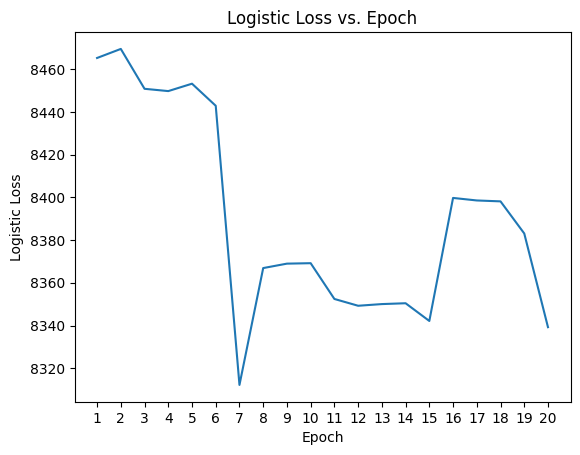

On Test Set: -------------------
Accuracy:  0.2408888888888889


In [ ]:
### testing: using best hyperparameters, train model and test on test data

#####
train = BOW_train
test = BOW_test
#####

# LR_0 = bestHyperparameters["LR_0"]
# sig2 = bestHyperparameters["sig2"]

LR_0 = 0.1
sig2 = 100

train_data = train.drop('label', axis=1).values
train_labels = train['label'].values

w = Logistic_SGD(train_data, train_labels, LR_0, sig2, T, Logistic_obj_threshold, show_plot = True)

test_data = test.drop('label', axis=1).values
test_labels = test['label'].values
N = len(test_data)
correct = 0
accuracy = 0
for i in range(N):
    # this is where we need to do the false/true positive/negative stuff
    prediction = np.dot(w, test_data[i])
    actual = test_labels[i] 
    if prediction > 0: 
        prediction = 1
    else: 
        prediction = 0
    if prediction == actual:
        correct += 1
accuracy = correct/N


print("On Test Set: -------------------")
print("Accuracy: ", accuracy)


In [ ]:
eval_guesses_to_csv(w, BOW_eval.drop(columns=['label']), "SVM_logistic.BOW.eval.predictions.csv")

------ glove -------

In [ ]:
### testing: detemine best hyperparameters for Logistic SGD

T = 100 # we probs (shouldn't) reach this, cause it should stop on its own cause we'll converge to the bottom of the bowl
Logistic_obj_threshold = 0.001
LR_0_arr = [1, .1, .01, .001, .0001, .00001]
sig2_arr = [.1, 1, 10, 100, 1000, 10000]

bestHyperparameters = {"LR_0": 0, "sig2": 0, "avg_accuracy": 0}

train_folds = np.array_split(glove_train, 5)

for LR_0 in LR_0_arr:
    for sig2 in sig2_arr:
        avg_accuracy = CV_logistic(train_folds, sig2, LR_0, T, Logistic_obj_threshold)
        print(f'LR_0 = {LR_0}, sig2 = {sig2}, avg_accuracy = {avg_accuracy}')
        if avg_accuracy > bestHyperparameters["avg_accuracy"]:
            bestHyperparameters["LR_0"] = LR_0
            bestHyperparameters["sig2"] = sig2
            bestHyperparameters["avg_accuracy"] = avg_accuracy
print("best Hyperparameters: ", bestHyperparameters)   

C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 

LR_0 = 1, sig2 = 0.1, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarni

LR_0 = 1, sig2 = 1, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:61: RuntimeWarning: invalid value encountered in scalar subtract
  log_diff = abs(prev_logistic_obj - logistic_obj)
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ag

LR_0 = 1, sig2 = 10, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.p

LR_0 = 1, sig2 = 100, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probabli

LR_0 = 1, sig2 = 1000, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1


LR_0 = 1, sig2 = 10000, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probabl

LR_0 = 0.1, sig2 = 0.1, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))


LR_0 = 0.1, sig2 = 1, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1


LR_0 = 0.1, sig2 = 10, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probabli

LR_0 = 0.1, sig2 = 100, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1


LR_0 = 0.1, sig2 = 1000, avg_accuracy = 0.49777142857142864


C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probablity that the label is 1
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:46: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.log(1 + np.exp(-yi*np.dot(w.T, xi)))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\3907794492.py:22: RuntimeWarning: overflow encountered in exp
  sigmoid_term = 1 / (1 + np.exp(-z))
C:\Users\17ago\AppData\Local\Temp\ipykernel_11816\4266246686.py:18: RuntimeWarning: overflow encountered in exp
  prediction = 1/(1+np.exp(-np.dot(w.T, test_data[i]))) ## sigmoid, this should give us the probabl

LR_0 = 0.1, sig2 = 10000, avg_accuracy = 0.49777142857142864
LR_0 = 0.01, sig2 = 0.1, avg_accuracy = 0.49777142857142864
LR_0 = 0.01, sig2 = 1, avg_accuracy = 0.49777142857142864
LR_0 = 0.01, sig2 = 10, avg_accuracy = 0.49777142857142864
LR_0 = 0.01, sig2 = 100, avg_accuracy = 0.49777142857142864
LR_0 = 0.01, sig2 = 1000, avg_accuracy = 0.49777142857142864
LR_0 = 0.01, sig2 = 10000, avg_accuracy = 0.49777142857142864
LR_0 = 0.001, sig2 = 0.1, avg_accuracy = 0.49777142857142864
LR_0 = 0.001, sig2 = 1, avg_accuracy = 0.49777142857142864
LR_0 = 0.001, sig2 = 10, avg_accuracy = 0.49777142857142864
LR_0 = 0.001, sig2 = 100, avg_accuracy = 0.49777142857142864
LR_0 = 0.001, sig2 = 1000, avg_accuracy = 0.49777142857142864
LR_0 = 0.001, sig2 = 10000, avg_accuracy = 0.49777142857142864
LR_0 = 0.0001, sig2 = 0.1, avg_accuracy = 0.49777142857142864
LR_0 = 0.0001, sig2 = 1, avg_accuracy = 0.49777142857142864
LR_0 = 0.0001, sig2 = 10, avg_accuracy = 0.49777142857142864
LR_0 = 0.0001, sig2 = 100, avg

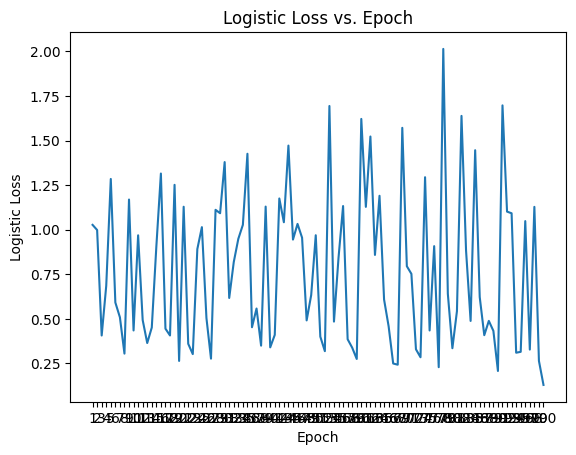

On Test Set: -------------------
Accuracy:  0.4831111111111111


In [ ]:
### testing: using best hyperparameters, train model and test on test data

#####
train = glove_train
test = glove_test
#####

LR_0 = bestHyperparameters["LR_0"]
sig2 = bestHyperparameters["sig2"]

train_data = train.drop('label', axis=1).values
train_labels = train['label'].values

w = Logistic_SGD(train_data, train_labels, LR_0, sig2, T, Logistic_obj_threshold, show_plot = True)

test_data = test.drop('label', axis=1).values
test_labels = test['label'].values
N = len(test_data)
correct = 0
accuracy = 0
for i in range(N):
    # this is where we need to do the false/true positive/negative stuff
    prediction = np.dot(w, test_data[i])
    actual = test_labels[i] 
    if prediction > 0 and actual == 1:
        correct += 1
    elif prediction < 0 and actual == -1:
        correct += 1
accuracy = correct/N


print("On Test Set: -------------------")
print("Accuracy: ", accuracy)


In [ ]:
eval_guesses_to_csv(w, glove_eval.drop(columns=['label']), "SVM_logistic.glove.eval.predictions.csv")

------ tfidf -------

In [ ]:
### testing: detemine best hyperparameters for Logistic SGD

T = 100 # we probs (shouldn't) reach this, cause it should stop on its own cause we'll converge to the bottom of the bowl
Logistic_obj_threshold = 0.001
LR_0_arr = [1, .1, .01, .001, .0001, .00001]
sig2_arr = [.1, 1, 10, 100, 1000, 10000]

bestHyperparameters = {"LR_0": 0, "sig2": 0, "avg_accuracy": 0}

train_folds = np.array_split(tfidf_train, 5)

for LR_0 in LR_0_arr:
    for sig2 in sig2_arr:
        avg_accuracy = CV_logistic(train_folds, sig2, LR_0, T, Logistic_obj_threshold)
        print(f'LR_0 = {LR_0}, sig2 = {sig2}, avg_accuracy = {avg_accuracy}')
        if avg_accuracy > bestHyperparameters["avg_accuracy"]:
            bestHyperparameters["LR_0"] = LR_0
            bestHyperparameters["sig2"] = sig2
            bestHyperparameters["avg_accuracy"] = avg_accuracy
print("best Hyperparameters: ", bestHyperparameters)   

C:\Users\17ago\AppData\Local\Temp\ipykernel_15544\3663674511.py:19: RuntimeWarning: overflow encountered in exp
  logistic_obj = np.sum(np.log(1 + np.exp(-yi*np.dot(w, xi)))) + (1 / sig2**2) * np.dot(w, w)
C:\Users\17ago\AppData\Local\Temp\ipykernel_15544\3663674511.py:34: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(prev_logistic_obj - logistic_obj) < threshold:
C:\Users\17ago\AppData\Local\Temp\ipykernel_15544\3663674511.py:15: RuntimeWarning: overflow encountered in exp
  gradient = np.exp(-yi*np.dot(w, xi))*yi*xi/(1 + np.exp(-yi*np.dot(w, xi))) + (2/sig2**2)*w
C:\Users\17ago\AppData\Local\Temp\ipykernel_15544\3663674511.py:15: RuntimeWarning: invalid value encountered in multiply
  gradient = np.exp(-yi*np.dot(w, xi))*yi*xi/(1 + np.exp(-yi*np.dot(w, xi))) + (2/sig2**2)*w
C:\Users\17ago\AppData\Local\Temp\ipykernel_15544\3663674511.py:15: RuntimeWarning: invalid value encountered in divide
  gradient = np.exp(-yi*np.dot(w, xi))*yi*xi/(1 + np.exp(-yi*np.dot(w

LR_0 = 1, sig2 = 0.1, avg_accuracy = 0.0
LR_0 = 1, sig2 = 1, avg_accuracy = 0.4758857142857143
LR_0 = 1, sig2 = 10, avg_accuracy = 0.4461142857142857
LR_0 = 1, sig2 = 100, avg_accuracy = 0.4723428571428571
LR_0 = 1, sig2 = 1000, avg_accuracy = 0.4614857142857143
LR_0 = 1, sig2 = 10000, avg_accuracy = 0.45051428571428576
LR_0 = 0.1, sig2 = 0.1, avg_accuracy = 0.48897142857142856
LR_0 = 0.1, sig2 = 1, avg_accuracy = 0.4588
LR_0 = 0.1, sig2 = 10, avg_accuracy = 0.45931428571428573
LR_0 = 0.1, sig2 = 100, avg_accuracy = 0.4565714285714286
LR_0 = 0.1, sig2 = 1000, avg_accuracy = 0.4378285714285714
LR_0 = 0.1, sig2 = 10000, avg_accuracy = 0.43114285714285716
LR_0 = 0.01, sig2 = 0.1, avg_accuracy = 0.41348571428571435
LR_0 = 0.01, sig2 = 1, avg_accuracy = 0.3564
LR_0 = 0.01, sig2 = 10, avg_accuracy = 0.44451428571428575
LR_0 = 0.01, sig2 = 100, avg_accuracy = 0.4143428571428571
LR_0 = 0.01, sig2 = 1000, avg_accuracy = 0.43971428571428567
LR_0 = 0.01, sig2 = 10000, avg_accuracy = 0.42211428571

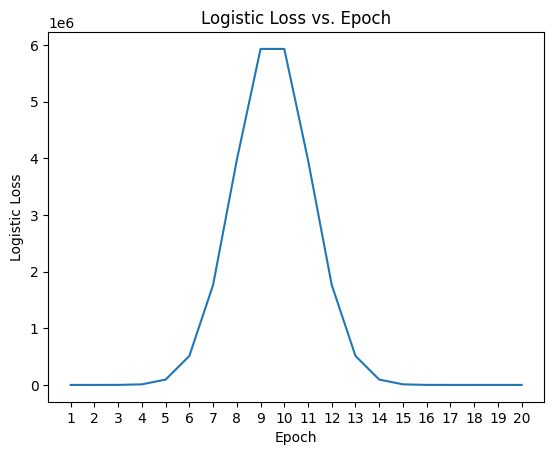

On Test Set: -------------------
Accuracy:  0.4622222222222222


In [ ]:
### testing: using best hyperparameters, train model and test on test data

#####
train = tfidf_train
test = tfidf_test
#####

LR_0 = bestHyperparameters["LR_0"]
sig2 = bestHyperparameters["sig2"]

train_data = train.drop('label', axis=1).values
train_labels = train['label'].values

w = Logistic_SGD(train_data, train_labels, LR_0, sig2, T, Logistic_obj_threshold, show_plot = True)

test_data = test.drop('label', axis=1).values
test_labels = test['label'].values
N = len(test_data)
correct = 0
accuracy = 0
for i in range(N):
    # this is where we need to do the false/true positive/negative stuff
    prediction = np.dot(w, test_data[i])
    actual = test_labels[i] 
    if prediction > 0 and actual == 1:
        correct += 1
    elif prediction < 0 and actual == -1:
        correct += 1
accuracy = correct/N


print("On Test Set: -------------------")
print("Accuracy: ", accuracy)


In [ ]:
eval_guesses_to_csv(w, tfidf_eval.drop(columns=['label']), "SVM_logistic.tfidf.eval.predictions.csv")